In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




In [94]:
combined_stats = pd.read_csv('Data/FantasyFootball_2025.csv')

In [96]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthGrades,2023HealthGrades2,2023Cmp,2023Att,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,6,Lamar Jackson,BAL,QB,26,16,0.0,Healthy,307,457,...,6,148.0,952,4,0,0,0,5,40,479.2
1,21,Ja'Marr Chase,CIN,WR,23,16,0.0,Healthy,1,1,...,0,3.0,21,0,119,1607,14,0,14,367.1
2,1,Josh Allen,BUF,QB,27,17,0.0,Healthy,385,579,...,6,113.0,561,10,0,0,0,2,41,431.3
3,11,Joe Burrow,CIN,QB,27,10,3.0,Moderate Injuries,244,365,...,9,44.0,190,3,0,0,0,4,42,439.1
4,26,Baker Mayfield,TAM,QB,28,17,0.0,Healthy,364,566,...,18,61.0,326,3,0,0,0,3,38,389.7


In [98]:
combined_stats.groupby('FantPos')['2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,284.184211,121.760020,15.7,270.55,315.3,356.35,479.2
RB,89.0,141.832584,80.899598,35.3,82.30,125.8,190.40,316.9
TE,45.0,137.075556,51.315079,54.4,104.60,128.8,166.50,262.6
WR,109.0,176.338532,63.752098,0.0,131.00,159.4,219.10,367.1


In [100]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           237 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023HealthGrades             271 non-null    float64
 7   2023HealthGrades2            271 non-null    object 
 8   2023Cmp                      281 non-null    int64  
 9   2023Att                      281 non-null    int64  
 10  2023PassYds                  281 non-null    int64  
 11  2023PassTD                   281 non-null    int64  
 12  2023Int                      281 non-null    int64  
 13  2023RushAtt         

In [102]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [104]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate data using Train, Test, and Split with Random Forest Regressor.

In [110]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=20, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', '2025PPR']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'Predicted Fantasy Points'] = y_pred_train

    test_df = position_data.loc[idx_test, ['Player', 'FantPos', '2025PPR']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'Predicted Fantasy Points'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']



# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_RFR.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 13.06874195171026
RB - Testing MAE: 34.45120548941801

RB - Feature Importances:
        Feature  Importance
7   2024RushAtt    0.492375
11   2024RecYds    0.133619
9    2024RushTD    0.112071
10      2024Rec    0.047078
0   2023RushAtt    0.044123
1   2023RushYds    0.041080
3       2023Rec    0.019845
8   2024RushYds    0.017724
4     2023RecTD    0.017629
15      2025Age    0.013543
6        2023TD    0.013285
12    2024RecTD    0.012613
2    2023RushTD    0.012470
14  HealthGrade    0.011653
13       2024FL    0.007572
5        2023FL    0.003320

WR - Training MAE: 12.452546380263993
WR - Testing MAE: 25.01429496179321

WR - Feature Importances:
        Feature  Importance
10      2024Rec    0.608911
3       2023Rec    0.064120
12    2024RecTD    0.055277
11   2024RecYds    0.051104
15      2025Age    0.050544
1   2023RushYds    0.039279
0   2023RushAtt    0.036668
14  HealthGrade    0.023253
7   2024RushAtt    0.016410
6        2023TD    0.015792
4     2023Rec

In [112]:

# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.889  17.39
1       WR  0.875  14.99
2       TE  0.889  12.47
3       QB  0.660  43.76


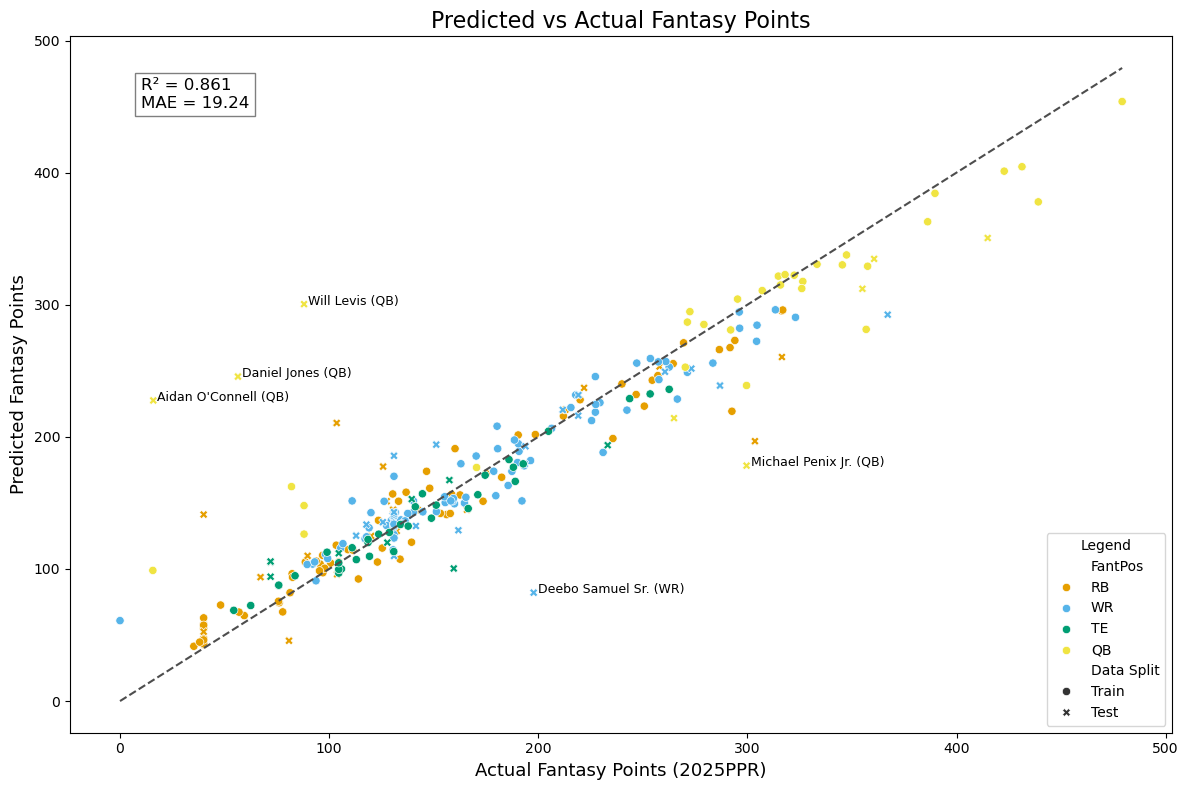

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_predictions,
    x='2025PPR', y='Predicted Fantasy Points',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['2025PPR'].min()
max_val = all_predictions['2025PPR'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual Fantasy Points', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

## Now we will use Cross Validation to determine the fantasy football projected scores without the 2025 projected data.

In [117]:
# Function to train and predict for a specific position using cross-validation

def train_and_predict_cv(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Get out-of-fold predictions (no leakage)
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Calculate CV MAE
    mae = mean_absolute_error(y, y_pred)
    print(f"\n{position} - Cross-Validated MAE: {mae:.2f}")

    # Fit the model on the full dataset to get final feature importances
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted Fantasy Points'] = y_pred

    return position_data[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict_cv('RB', rb_features)
wr_predictions = train_and_predict_cv('WR', wr_features)
te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 33.81

RB - Feature Importances:
        Feature  Importance
7   2024RushAtt    0.384273
9    2024RushTD    0.254867
11   2024RecYds    0.104855
1   2023RushYds    0.058391
10      2024Rec    0.028444
8   2024RushYds    0.024286
6        2023TD    0.023247
0   2023RushAtt    0.020820
12    2024RecTD    0.018158
3       2023Rec    0.016570
2    2023RushTD    0.015708
15      2025Age    0.012854
14  HealthGrade    0.012667
4     2023RecTD    0.012617
13       2024FL    0.008483
5        2023FL    0.003761

WR - Cross-Validated MAE: 30.98

WR - Feature Importances:
        Feature  Importance
10      2024Rec    0.634863
3       2023Rec    0.078530
12    2024RecTD    0.059994
11   2024RecYds    0.059826
15      2025Age    0.031741
0   2023RushAtt    0.025972
1   2023RushYds    0.025845
14  HealthGrade    0.016195
8   2024RushYds    0.012956
7   2024RushAtt    0.011421
4     2023RecTD    0.010739
6        2023TD    0.010137
5        2023FL    0.008426
9    2024Rus

In [119]:

# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.676  33.81
1       WR  0.549  30.98
2       TE  0.610  26.28
3       QB  0.354  69.51


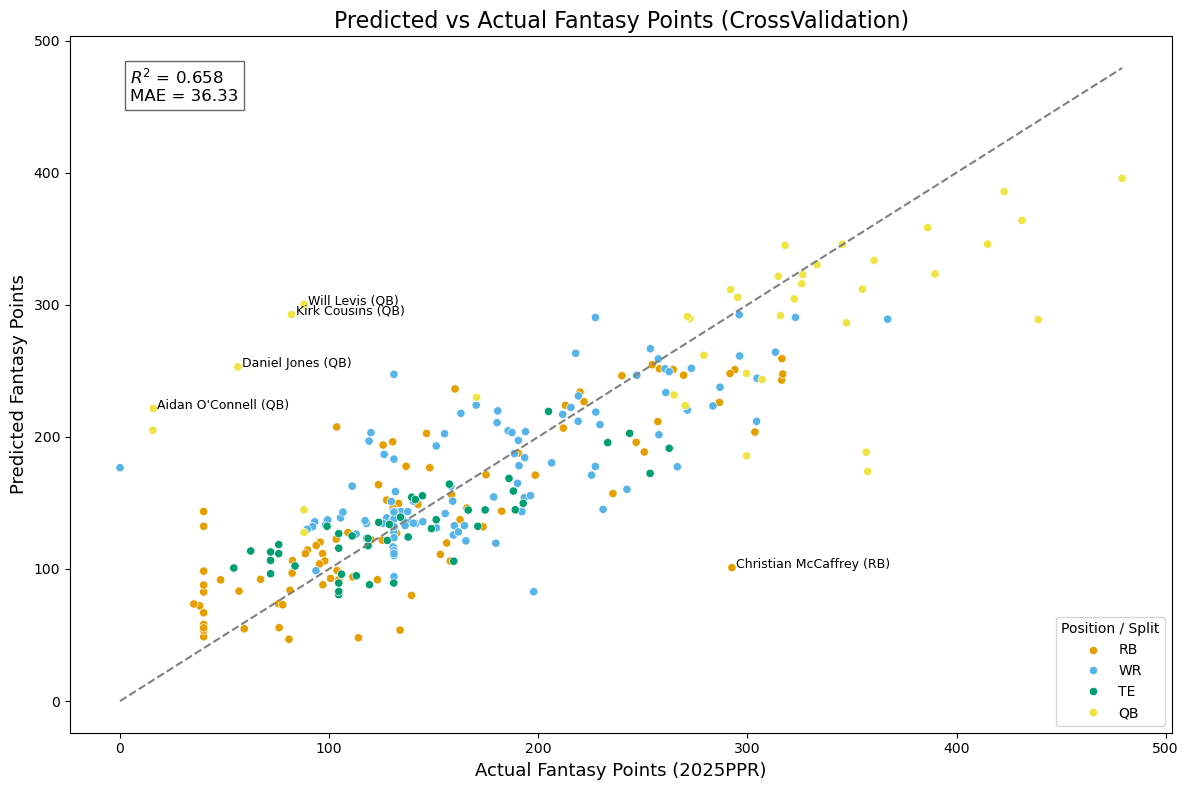

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (CrossValidation)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

## Function to train and predict for a specific position using RandomizedSearchCV without the 2025 projected data.

In [124]:
'''
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()

    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Define hyperparameter search space
    param_distributions = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Initialize the base model
    rf = RandomForestRegressor(random_state=42)

    # Set up RandomizedSearchCV with internal 3-fold CV
    rf_random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=30,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Fit the randomized search to find best hyperparameters
    rf_random_search.fit(X, y)
    best_rf = rf_random_search.best_estimator_

    # Show best hyperparameters
    print(f"\n{position} - Best Hyperparameters:")
    print(rf_random_search.best_params_)

    # Use cross_val_predict with the best model
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(best_rf, X, y, cv=kf, n_jobs=-1)

    # Evaluate CV performance
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"{position} - Cross-Validated MAE: {mae_cv:.2f}")

    # Store out-of-fold predictions
    position_data['Predicted Fantasy Points'] = np.ceil(y_pred_cv)
    position_data['Data Split'] = 'Cross-Validated'

    # Feature importances from final fit on all data
    best_rf.fit(X, y)
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]
# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023G', '2023FL', '2023TD', '2024G', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
qb_features = ['PassYds', '2023PassTD', '2023RushAtt', '2023RushYds', '2023RushTD', '2023G', '2023FL', '2023TD', '2024G', '2024RushAtt', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

# Train and predict for each position
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

# Save the projected data to a new CSV file
output_path = "Data/FantasyFootballPrediction_RSCV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)

Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.704  33.10
1       WR  0.600  29.60
2       TE  0.407  29.59
3       QB  0.248  79.08

Negligible performance, so saving computing power and not running the code/script.

'''

'\ndef train_and_predict(position, features):\n    # Filter data for the specific position\n    position_data = combined_stats[combined_stats[\'FantPos\'] == position].copy()\n\n    if position_data.empty:\n        print(f"No data found for position: {position}")\n        return pd.DataFrame()\n\n    X = position_data[features].fillna(0)\n    y = position_data[\'2025PPR\'].fillna(0)\n\n    # Define hyperparameter search space\n    param_distributions = {\n        \'n_estimators\': [100, 200, 300],\n        \'max_depth\': [10, 20, 30],\n        \'min_samples_split\': [2, 5, 10],\n        \'min_samples_leaf\': [1, 2, 4],\n        \'max_features\': [\'sqrt\', \'log2\']\n    }\n\n    # Initialize the base model\n    rf = RandomForestRegressor(random_state=42)\n\n    # Set up RandomizedSearchCV with internal 3-fold CV\n    rf_random_search = RandomizedSearchCV(\n        estimator=rf,\n        param_distributions=param_distributions,\n        n_iter=30,\n        cv=3,\n        scoring=\'neg_

## Combined CV + Full-Training Prediction Function

* Combined version of train_and_predict_cv function that:
* Uses cross_val_predict to evaluate out-of-fold performance (for realistic MAE).
* Fits a final model on the full data to generate actual predicted fantasy points (for production use).
* Returns both the evaluation metrics and full-data predictions.

In [127]:
def train_and_predict_cv(position, features, cv=5):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # --- Step 1: Cross-validated prediction ---
    y_pred_cv = cross_val_predict(rf, X, y, cv=kf)

    # Compute CV MAE
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"\n{position} - Cross-Validated MAE (unseen): {mae_cv:.2f}")

    # --- Step 2: Final model trained on all data ---
    rf.fit(X, y)
    y_pred_final = rf.predict(X)  # Full-data predictions

    # Feature importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Add predictions to dataframe
    position_data['Predicted Fantasy Points (Final Model)'] = np.round(y_pred_final, 2)
    position_data['Predicted Fantasy Points (CV)'] = np.round(y_pred_cv, 2)
    position_data['Data Split'] = 'CrossVal + FullTrain'

    return position_data[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points (Final Model)', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
wr_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age']

# Train and predict for each position
rb_predictions = train_and_predict('RB', rb_features)
wr_predictions = train_and_predict('WR', wr_features)
te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wr_predictions, te_predictions, qb_predictions]).round(2)

# Save the projected data to a new CSV file
output_path = "Data/FantasyFootballPrediction_CVFT.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 13.06874195171026
RB - Testing MAE: 34.45120548941801

RB - Feature Importances:
        Feature  Importance
7   2024RushAtt    0.492375
11   2024RecYds    0.133619
9    2024RushTD    0.112071
10      2024Rec    0.047078
0   2023RushAtt    0.044123
1   2023RushYds    0.041080
3       2023Rec    0.019845
8   2024RushYds    0.017724
4     2023RecTD    0.017629
15      2025Age    0.013543
6        2023TD    0.013285
12    2024RecTD    0.012613
2    2023RushTD    0.012470
14  HealthGrade    0.011653
13       2024FL    0.007572
5        2023FL    0.003320

WR - Training MAE: 12.452546380263993
WR - Testing MAE: 25.01429496179321

WR - Feature Importances:
        Feature  Importance
10      2024Rec    0.608911
3       2023Rec    0.064120
12    2024RecTD    0.055277
11   2024RecYds    0.051104
15      2025Age    0.050544
1   2023RushYds    0.039279
0   2023RushAtt    0.036668
14  HealthGrade    0.023253
7   2024RushAtt    0.016410
6        2023TD    0.015792
4     2023Rec

* Predicted Fantasy Points (CV)	CV-based out-of-fold prediction (realistic error)
* Predicted Fantasy Points (Final Model)	Model trained on full data (for use)
* 2025PPR	Actual fantasy points

In [130]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.889  17.39
1       WR  0.875  14.99
2       TE  0.889  12.47
3       QB  0.660  43.76


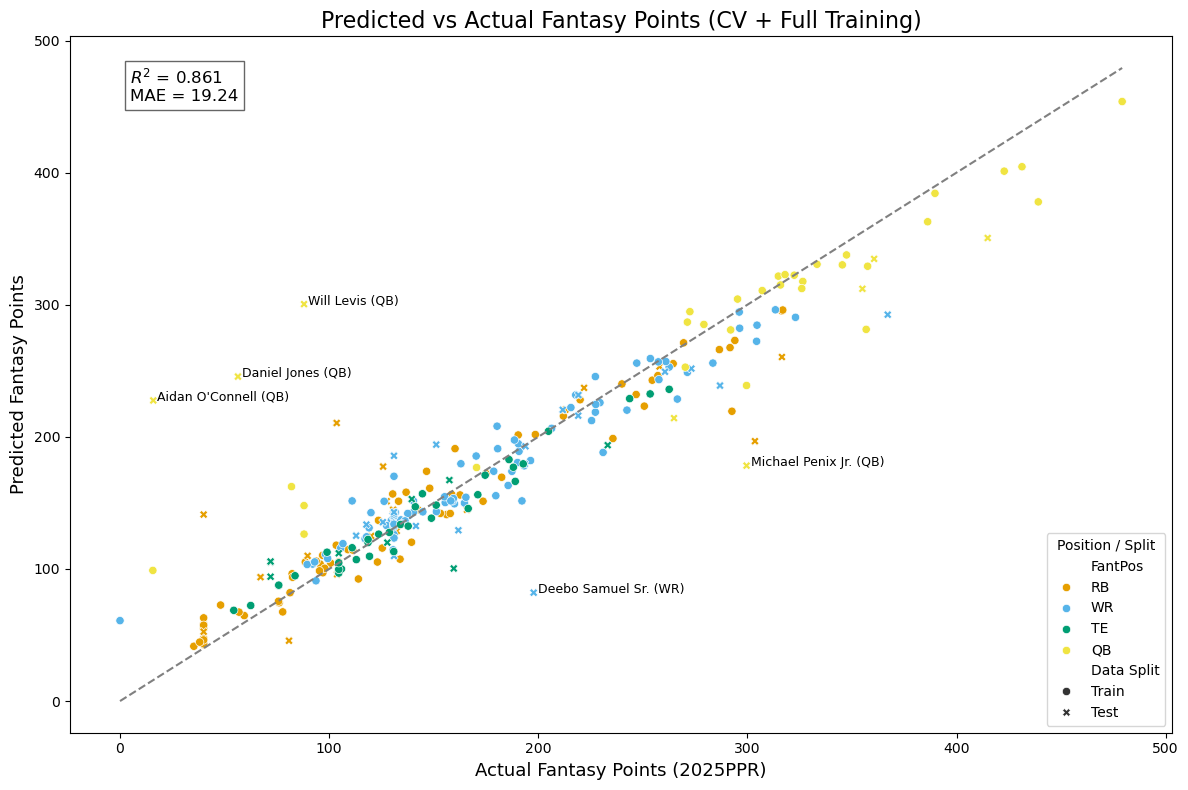

In [132]:
# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR': '#56B4E9',  # blue
    'TE': '#009E73',  # green
    'QB': '#F0E442'   # yellow
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    style='Data Split',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (CV + Full Training)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()